In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

In [2]:
player_season_stats_df = pd.read_csv('data/totals_stats.csv') # Downloaded from S3; scraped from Basketball Reference

### Some preprocessing ###

# Discard rows with significant missing data
mask_missing_team_or_season = (player_season_stats_df['Season'].isna()) | (player_season_stats_df['Team'].isna())
player_season_stats_df = player_season_stats_df[~mask_missing_team_or_season]

# Fill missing awards
player_season_stats_df['Awards'] = player_season_stats_df['Awards'].fillna('NO_AWARD')

# Remove rows with missing Position as this is the target variable of interest
    # ~3.7% of the data
player_season_stats_df = player_season_stats_df[~player_season_stats_df['Pos'].isna()]

# Change format of season (e.g. 2010-2011 --> 2010)
player_season_stats_df['Season'] = player_season_stats_df['Season'].str.split('-').str[0].astype(int)

# Data prior to the year 2000 contains the majority of nulls; removing these.
player_season_stats_df = player_season_stats_df[player_season_stats_df['Season'] > 2000]

# Impute mean in remaining missing values
player_season_stats_df = player_season_stats_df.fillna(player_season_stats_df.mean(numeric_only=True))

numerical_cols = player_season_stats_df.select_dtypes(include='number').columns.tolist()

player_season_stats_df.head()

,Season,Age,Team,Lg,G,MP,FG,FGA,FG%,3P,3PA,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,TOV,PF,PTS,Trp-Dbl,Awards,player_id,Pos,GS,3P%,STL,BLK
1,2010,24,MIN,NBA,42.0,419.0,55.0,154.0,0.357,17.0,60.0,38.0,94.0,0.404,0.412,33.0,42.0,0.786,23.0,47.0,70.0,28.0,19.0,44.0,160.0,0.0,NO_AWARD,haywala01,SF,0.0,0.283,12.0,7.0
2,2011,25,OKC,NBA,26.0,141.0,13.0,38.0,0.342,4.0,14.0,9.0,24.0,0.375,0.395,7.0,12.0,0.583,2.0,14.0,16.0,4.0,9.0,18.0,37.0,0.0,NO_AWARD,haywala01,SF,0.0,0.286,3.0,1.0
3,2012,26,MIN,NBA,4.0,31.0,2.0,10.0,0.200,0.0,4.0,2.0,6.0,0.333,0.200,6.0,6.0,1.000,0.0,4.0,4.0,3.0,0.0,3.0,10.0,0.0,NO_AWARD,haywala01,SF,0.0,0.000,2.0,0.0
4,2019,23,SAC,NBA,36.0,232.0,35.0,84.0,0.417,9.0,29.0,26.0,55.0,0.473,0.470,10.0,21.0,0.476,6.0,26.0,32.0,18.0,8.0,17.0,89.0,0.0,NO_AWARD,jamesju01,SF,0.0,0.310,6.0,9.0
5,2020,24,SAC,NBA,36.0,310.0,52.0,111.0,0.468,14.0,38.0,38.0,73.0,0.521,0.532,21.0,36.0,0.583,9.0,21.0,30.0,22.0,15.0,23.0,139.0,0.0,NO_AWARD,jamesju01,SF,0.0,0.368,8.0,3.0


In [3]:
# Transform dataset to player-position level rather than player-season level
    # Simply take mean at the player-position level (accounts for players who played multiple positions)
player_position_df = player_season_stats_df.groupby(['player_id', 'Pos'])[numerical_cols].mean().reset_index()
player_position_df['is_C_or_PF'] = (player_position_df['Pos'].isin(['C', 'PF'])).astype(int)
player_position_df

,player_id,Pos,Season,G,MP,FG,FGA,FG%,3P,3PA,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,TOV,PF,PTS,Trp-Dbl,GS,3P%,STL,BLK,is_C_or_PF
0,abdulta01,SG,2001.250000,15.500000,271.500000,34.250000,88.000000,0.304750,0.500000,1.250000,33.750000,86.750000,0.306000,0.306750,12.750000,18.000000,0.494250,24.000000,28.000000,52.000000,17.250000,15.250000,34.500000,81.750000,0.000000,6.000000,0.323454,11.500000,5.750000,0
1,abdursh01,C,2006.000000,80.000000,2015.000000,310.000000,654.000000,0.474000,3.000000,20.000000,307.000000,634.000000,0.484000,0.476000,170.000000,234.000000,0.726000,122.000000,276.000000,398.000000,109.000000,116.000000,243.000000,793.000000,0.000000,45.000000,0.150000,53.000000,40.000000,1
2,abdursh01,PF,2003.500000,57.500000,1914.250000,354.750000,738.000000,0.448500,10.000000,32.375000,344.750000,705.625000,0.455125,0.454500,257.750000,307.250000,0.859125,123.250000,303.000000,426.250000,136.625000,132.000000,160.500000,977.250000,0.000000,43.625000,0.300227,52.375000,32.625000,1
3,abrinal01,SG,2017.000000,58.000000,925.666667,101.666667,263.000000,0.381667,73.000000,198.333333,28.666667,64.666667,0.456333,0.519333,31.666667,36.000000,0.889667,16.333333,66.333333,82.666667,29.333333,24.000000,97.000000,308.000000,0.000000,5.333333,0.361333,30.666667,7.333333,0
4,achiupr01,C,2022.500000,52.500000,1118.000000,175.750000,376.000000,0.471250,27.000000,86.750000,148.750000,289.250000,0.522250,0.505250,57.500000,91.500000,0.615500,99.250000,214.250000,313.500000,57.750000,54.250000,93.500000,436.000000,0.000000,12.500000,0.295750,32.750000,31.250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3312,zimmede01,PG,2005.000000,2.000000,32.000000,2.000000,3.000000,0.667000,0.000000,0.000000,2.000000,3.000000,0.667000,0.667000,0.000000,0.000000,0.731413,1.000000,3.000000,4.000000,7.000000,4.000000,4.000000,4.000000,0.000000,0.000000,0.293815,0.000000,0.000000,0
3313,zimmest01,C,2016.000000,19.000000,108.000000,10.000000,31.000000,0.323000,0.000000,0.000000,10.000000,31.000000,0.323000,0.323000,3.000000,5.000000,0.600000,11.000000,24.000000,35.000000,4.000000,3.000000,17.000000,23.000000,0.000000,0.000000,0.293815,2.000000,5.000000,1
3314,zipsepa01,SF,2016.500000,49.000000,833.500000,84.500000,227.500000,0.372000,35.000000,104.500000,49.500000,123.000000,0.403000,0.449000,25.000000,32.500000,0.767500,14.000000,114.000000,128.000000,41.000000,41.500000,82.000000,229.000000,0.000000,15.000000,0.334500,17.500000,15.500000,0
3315,zizican01,C,2018.000000,37.666667,505.666667,91.000000,156.666667,0.617667,0.000000,0.000000,91.000000,156.666667,0.617667,0.617667,42.666667,60.000000,0.722000,50.000000,98.666667,148.666667,21.333333,27.333333,56.666667,224.666667,0.000000,9.000000,0.293815,7.333333,13.333333,1


In [4]:
# Identify columns 
grouped_mean_agg_df = player_position_df.groupby('is_C_or_PF')[numerical_cols].agg('mean').reset_index()

feature_coef_variation = (grouped_mean_agg_df[numerical_cols].std(axis=0) / grouped_mean_agg_df[numerical_cols].mean(axis=0)).sort_values(ascending = False)
feature_coef_variation = feature_coef_variation[feature_coef_variation >= feature_coef_variation.median()]
noteworthy_features_of_variation = feature_coef_variation.index.tolist()

print('These are the features that vary most by player position:')
grouped_mean_agg_df[['is_C_or_PF'] + noteworthy_features_of_variation].style.background_gradient(cmap='Greens')

These are the features that vary most by player position:


,is_C_or_PF,BLK,ORB,3P,3PA,AST,TRB,DRB,STL,PF,2P,3P%,FG%,FGA,Trp-Dbl
0,0,9.880572,23.740801,36.012451,102.151883,86.749453,110.176270,86.435469,27.756199,65.048073,88.049442,0.298969,0.397805,286.882297,0.083310
1,1,25.547181,56.926289,16.061169,46.403038,48.116523,190.498826,133.572537,21.135779,81.388784,104.563200,0.253134,0.459410,249.218290,0.073191


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = player_position_df.copy()
df_scaled[noteworthy_features_of_variation] = scaler.fit_transform(df_scaled[noteworthy_features_of_variation])

group_means = df_scaled.groupby("Pos")[noteworthy_features_of_variation].mean()
cos_sim = cosine_similarity(group_means)

print('The below table shows a measure of similarity between the positions. \nAs expected, Centers (C) and Power Forwards (PF) are very similar, \nso separating them from the data should be relatively straightforward.')

pd.DataFrame(cos_sim, index = group_means.index, columns = group_means.index).style.background_gradient(cmap='Greens')



The below table shows a measure of similarity between the positions. 
As expected, Centers (C) and Power Forwards (PF) are very similar, 
so separating them from the data should be relatively straightforward.


Pos,C,PF,PG,SF,SG
Pos,,,,,
C,1.000000,0.939261,-0.867696,-0.763505,-0.975345
PF,0.939261,1.000000,-0.916471,-0.603663,-0.962718
PG,-0.867696,-0.916471,1.000000,0.348450,0.820069
SF,-0.763505,-0.603663,0.348450,1.000000,0.783451
SG,-0.975345,-0.962718,0.820069,0.783451,1.000000


/Users/jacob/Documents/GitHub/jacobs_ml_fundamentals/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jacob/Documents/GitHub/jacobs_ml_fundamentals/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/jacob/Documents/GitHub/jacobs_ml_fundamentals/.venv/lib/python3.13/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


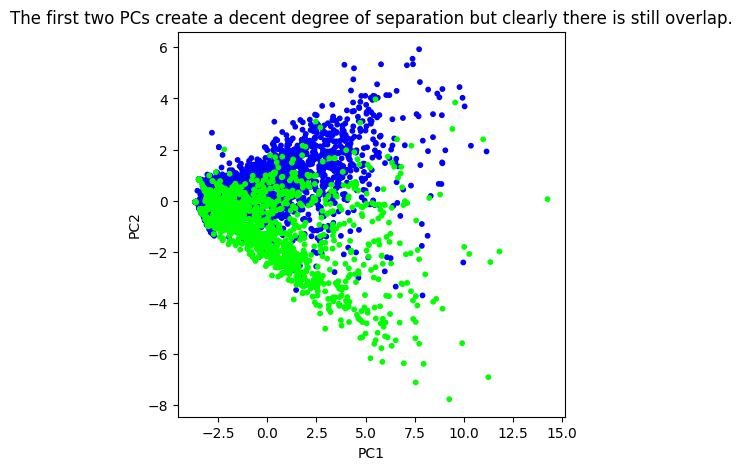

In [15]:
# Visualise target groups using PCA with 2 components

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_df = player_position_df[noteworthy_features_of_variation].copy()

# Standardize
scaler = StandardScaler()
scaled = scaler.fit_transform(pca_df)

# PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(scaled)

player_position_df[['PC1', 'PC2', 'PC3', 'PC4']] = pca_result

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(
    x = player_position_df.sort_values('is_C_or_PF')['PC1'],
    y = player_position_df.sort_values('is_C_or_PF')['PC2'],
    c = player_position_df.sort_values('is_C_or_PF')['is_C_or_PF'],
    cmap = 'brg',
        s = 10
)

plt.title('The first two PCs create a decent degree of separation but clearly there is still overlap.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

df = player_position_df

X = df[numerical_cols]
y = df['is_C_or_PF']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric="auc",
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))
auc_score = roc_auc_score(y_test, y_pred)
print(f"Overall ROC AUC score: {auc_score:.4f}")


              precision    recall  f1-score   support

           0       0.88      0.91      0.89       414
           1       0.83      0.79      0.81       250

    accuracy                           0.86       664
   macro avg       0.86      0.85      0.85       664
weighted avg       0.86      0.86      0.86       664

Overall ROC AUC score: 0.8469
